In [1]:
import torch, os, copy, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

from src.mechanism_base import *
from src.model_base import EmbedMLP
from src.utils import cross_entropy_high_precision, acc_rate

# Check if GPU is available
os.environ["CUDA_VISIBLE_DEVICES"] = os.environ.get("VSCODE_PROXY_CUDA_DEVICE", "")
# os.environ["CUDA_VISIBLE_DEVICES"] = os.environ["VSCODE_PROXY_CUDA_DEVICE"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Loading on device: {device}")

plt.rcParams['mathtext.fontset'] = 'cm'


Loading on device: cpu


In [2]:
# Define the base path where the model and data files are stored
base_path = '../saved_models/p_23_dmodel_23_dmlp_512_act_ReLU_decay_0_fractrain_1_DFT_05171140' # Full random, ReLU, Small Init, AdamW
#base_path = 'saved_models/p_23_dmodel_23_dmlp_512_act_ReLU_decay_0_fractrain_1_DFT_05101058' # Full random, ReLU, Small Init, SGD
#base_path = '../saved_models/p_23_dmodel_23_dmlp_512_act_ReLU_decay_0_fractrain_1_DFT_05171140' # Lottery Plot

# Set model configuration parameters
d_vocab, d_model, d_mlp, act_type = 23, 23, 512, 'ReLU'  # Vocabulary size, model dimension, MLP size, and activation type
p = d_vocab  # Assign vocabulary size to variable `p`

# Define the file names for the model and data files
model_file = 'final.pth'        # File containing the trained model
train_data_file = 'train_data.pth'  # File containing the training data
test_data_file = 'test_data.pth'   # File containing the test data

# Load the model and data on the specified device
# Note: The `weights_only=True` argument assumes a custom loader function or a modified PyTorch function. 
# It is not standard in PyTorch's `torch.load`. This should be clarified or corrected.
model_data = torch.load(
    os.path.join(base_path, model_file),   # Path to the model file
    weights_only=True,                    # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                   # Specify the device to load the model onto
)
print(f"Trained Model Dict: {model_data.keys()}\n")  # Print the keys of the loaded model dictionary

# Load the training and testing data
train_data = torch.load(
    os.path.join(base_path, train_data_file),  # Path to the training data file
    weights_only=True,                         # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                        # Specify the device to load the data onto
)
test_data = torch.load(
    os.path.join(base_path, test_data_file),   # Path to the testing data file
    weights_only=True,                         # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                        # Specify the device to load the data onto
)

# Extract the model parameters from the loaded model dictionary
model_load = model_data["model"]  # Access the model section of the dictionary
for key in model_load.keys():
    # Print each model parameter's key and its shape in a formatted manner
    print(f"{key:<30} {str(model_load[key].shape):<25}")

Trained Model Dict: dict_keys(['model', 'train_loss', 'test_loss', 'train_losses', 'test_losses', 'grad_norms', 'param_norms', 'epoch', 'optimizer', 'scheduler'])

embed.W_E                      torch.Size([23, 23])     
mlp.W_in                       torch.Size([512, 23])    
mlp.W_out                      torch.Size([23, 512])    
mlp.basis                      torch.Size([23, 23])     


In [3]:
all_data = torch.tensor([(i, j) for i in range(p) for j in range(p)]).to(device)
all_labels = torch.tensor([(i + j) % p for i, j in all_data]).to(device)
train_labels = torch.tensor([(i + j) % p for i, j in train_data]).to(device)

fourier_basis, fourier_basis_names = get_fourier_basis(p, device)
fourier_basis_unstd, _ = get_fourier_basis_unstd(p, device)

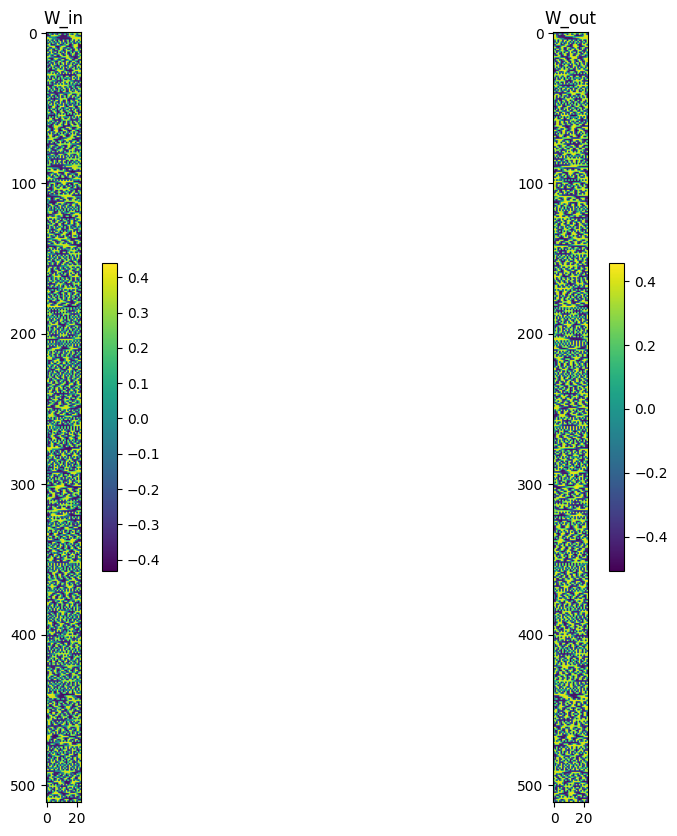

In [4]:
# Plot all four figures in one row
plt.figure(figsize=(12, 10))

# Heatmap (Binary Matrix from train_data)
plt.subplot(1, 2, 1)
#plt.imshow(model_load['mlp.W_in'] @ model_load['embed.W_E'], cmap='viridis')
plt.imshow(model_load['mlp.W_in'], cmap='viridis')
plt.title(f'W_in')
plt.colorbar(shrink=0.4)

# Heatmap (Binary Matrix from train_data)
plt.subplot(1, 2, 2) 
plt.imshow(model_load['mlp.W_out'].T, cmap='viridis')
plt.title(f'W_out')
plt.colorbar(shrink=0.4)

plt.show()

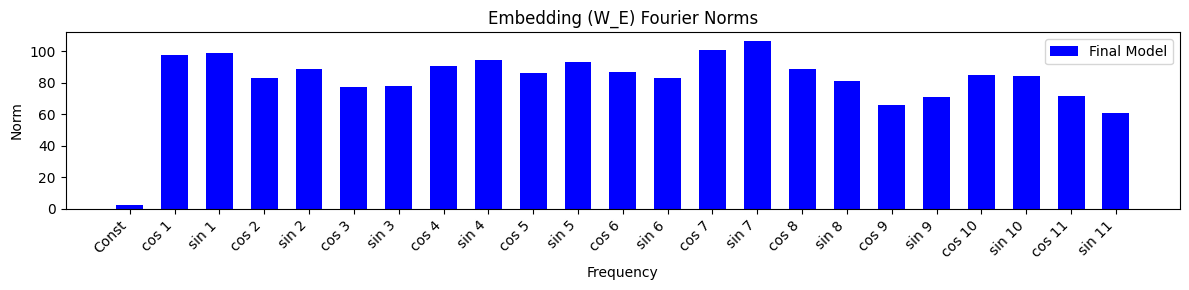

In [5]:
# Compute the norms of the Fourier components
#norms = (model_load['mlp.W_in'] @ model_load['embed.W_E'] @ fourier_basis.T).pow(2).sum(0).detach().cpu().numpy()
norms = (model_load['mlp.W_out'].T @ fourier_basis.T).pow(2).sum(0).detach().cpu().numpy()
#norms = (model_load['mlp.W_in']@ fourier_basis.T).pow(2).sum(0).detach().cpu().numpy()

# Plot the bar plot for "embed.W_E"
fig, ax = plt.subplots(figsize=(12, 3))

# x-axis labels
labels = fourier_basis_names
x = np.arange(len(labels))  # Frequency indices
width = 0.6  # Width of the bars

# Plot bars for the final model
ax.bar(x, norms, width, label="Final Model", color="blue")

# Customize plot
ax.set_title("Embedding (W_E) Fourier Norms")
ax.set_ylabel("Norm")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend()

# Add x-axis label and adjust layout
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

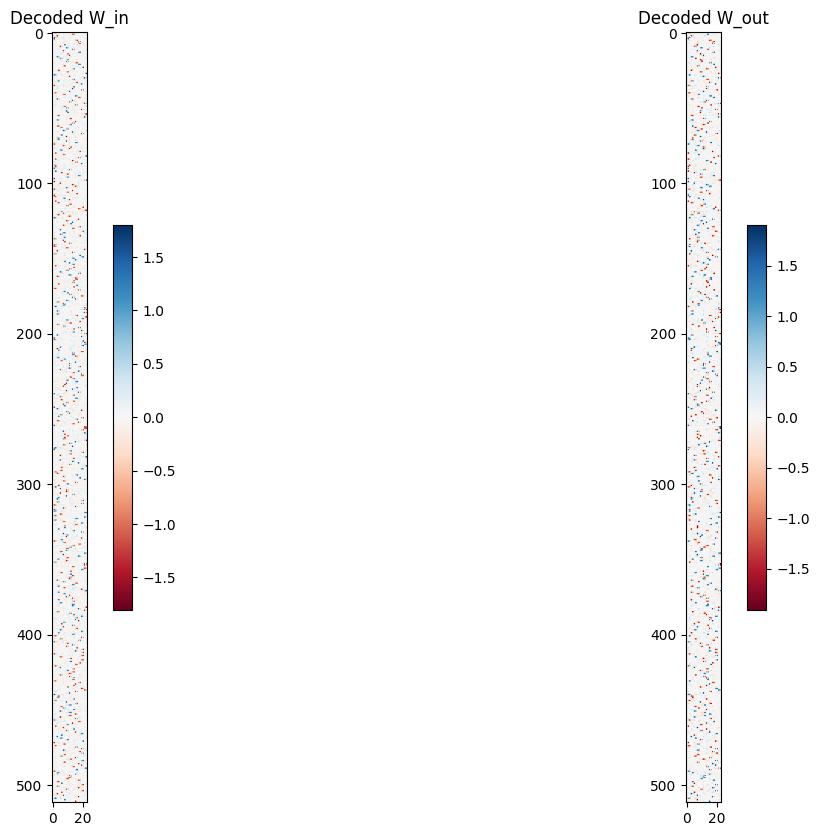

In [6]:
# Plot all four figures in one row
plt.figure(figsize=(15, 10))

# Heatmap (Binary Matrix from train_data)
plt.subplot(1, 2, 1)
#data = model_load['mlp.W_in'] @ model_load['embed.W_E'] @ fourier_basis.T
data = model_load['mlp.W_in'] @ fourier_basis.T
abs_max = np.abs(data).max()
plt.imshow(data, cmap='RdBu', vmin=-abs_max, vmax=abs_max)
plt.title(f'Decoded W_in')
plt.colorbar(shrink=0.5)

# Heatmap (Binary Matrix from train_data)
plt.subplot(1, 2, 2)
data = model_load['mlp.W_out'].T @ fourier_basis.T
abs_max = np.abs(data).max()
plt.imshow(data, cmap='RdBu', vmin=-abs_max, vmax=abs_max)
plt.title(f'Decoded W_out')
plt.colorbar(shrink=0.5)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")

plt.show()

In [7]:
def decode_weights(model_load, fourier_basis_unstd):
    """
    Decodes the weights using the given model and Fourier basis, and computes the maximum frequency list.

    Parameters:
        model_load (dict): A dictionary containing the model's weights.
        fourier_basis_unstd (torch.Tensor): The Fourier basis matrix.

    Returns:
        tuple: A tuple containing:
            - W_in_decode (torch.Tensor): Decoded weights for W_in.
            - W_out_decode (torch.Tensor): Decoded weights for W_out.
            - max_freq_ls (list): List of maximum frequencies derived from W_in_decode.
    """
    # Decode the weights
    #W_in_decode = model_load['mlp.W_in'] @ model_load['embed.W_E'] @ fourier_basis_unstd.T
    W_in_decode = model_load['mlp.W_in'] @ fourier_basis_unstd.T
    W_out_decode = model_load['mlp.W_out'].T @ fourier_basis_unstd.T

    # Find the maximum frequency list
    max_ls = torch.argmax(abs(W_in_decode), dim=1)
    max_freq_ls = [(id.item() + 1) // 2 for id in max_ls]

    return W_in_decode, W_out_decode, max_freq_ls

In [8]:
W_in_decode, W_out_decode, max_freq_ls = decode_weights(model_load, fourier_basis)
coeff_in_scale_ls_all = []
coeff_out_scale_ls_all = []
coeff_phi_ls_all = []
coeff_psi_ls_all = []

for neuron in range(d_mlp):
    coeff_in_scale, coeff_in_phi = compute_neuron(neuron, max_freq_ls, W_in_decode)
    coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
    coeff_in_scale_ls_all.append(coeff_in_scale)
    coeff_phi_ls_all.append(coeff_in_phi)
    coeff_psi_ls_all.append(coeff_out_phi)
    print(f"Neuron {neuron}: Freq {max_freq_ls[neuron]} , Scale {coeff_in_scale:.2f},{coeff_out_scale:.2f}, 2*Phi(in) {normalize_to_pi(2*coeff_in_phi):.2f}, Phi(out) {coeff_out_phi:.2f}")

Neuron 0: Freq 1 , Scale 1.41,1.77, 2*Phi(in) 2.14, Phi(out) 2.09
Neuron 1: Freq 7 , Scale 1.55,1.76, 2*Phi(in) -1.50, Phi(out) -1.42
Neuron 2: Freq 2 , Scale 1.62,1.85, 2*Phi(in) 0.53, Phi(out) 0.52
Neuron 3: Freq 1 , Scale 1.45,1.77, 2*Phi(in) 1.04, Phi(out) 1.00
Neuron 4: Freq 1 , Scale 1.54,1.75, 2*Phi(in) 0.35, Phi(out) 0.15
Neuron 5: Freq 8 , Scale 1.68,1.86, 2*Phi(in) 2.52, Phi(out) 2.47
Neuron 6: Freq 9 , Scale 1.60,1.83, 2*Phi(in) 1.73, Phi(out) 1.88
Neuron 7: Freq 9 , Scale 1.51,1.83, 2*Phi(in) -2.33, Phi(out) -2.39
Neuron 8: Freq 4 , Scale 1.57,1.85, 2*Phi(in) 3.12, Phi(out) -3.03
Neuron 9: Freq 3 , Scale 1.67,1.86, 2*Phi(in) 0.86, Phi(out) 0.80
Neuron 10: Freq 5 , Scale 1.51,1.81, 2*Phi(in) -1.02, Phi(out) -0.94
Neuron 11: Freq 7 , Scale 1.59,1.80, 2*Phi(in) 1.51, Phi(out) 1.44
Neuron 12: Freq 4 , Scale 1.42,1.79, 2*Phi(in) 0.26, Phi(out) 0.30
Neuron 13: Freq 9 , Scale 1.78,1.92, 2*Phi(in) -2.12, Phi(out) -2.06
Neuron 14: Freq 5 , Scale 1.48,1.80, 2*Phi(in) 2.89, Phi(out) 2

In [9]:
coeff_in_scale_ls_all = np.array(coeff_in_scale_ls_all)
print(np.mean(coeff_in_scale_ls_all)) 
print(np.std(coeff_in_scale_ls_all)) 

1.5755952734680223
0.08417866405379905


In [10]:
coeff_scale_ls = []
coeff_phi_ls = []
freq = 2

for neuron in [i for i, value in enumerate(max_freq_ls) if value == freq]:
    coeff_in_scale, coeff_in_phi = compute_neuron(neuron, max_freq_ls, W_in_decode)
    coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
    coeff_scale_ls.append(coeff_in_scale*coeff_out_scale)
    coeff_phi_ls.append(coeff_in_phi)
    print(f"Neuron {neuron}: Freq {max_freq_ls[neuron]}, Scale(in,out) {coeff_in_scale: .2f},{coeff_out_scale: .2f}, Phi(out) {normalize_to_pi(coeff_out_phi): .2f}, Phi(in)*2 {normalize_to_pi(2*coeff_in_phi): .2f}")

coeff_scale_ls = np.array(coeff_scale_ls)
coeff_phi_ls = np.array(coeff_phi_ls)

#for i in [1,2,4,6]: print(f"*{i} Mean of Sin: {np.mean(np.sin(i*coeff_phi_ls))} Mean of Cos: {np.mean(np.cos(i*coeff_phi_ls))}")
#for i in [1,2,4]: print(f"*{i} Sin: {np.mean(coeff_scale_ls*np.sin(i*coeff_phi_ls))/np.mean(coeff_scale_ls)} Cos: {np.mean(coeff_scale_ls*np.cos(i*coeff_phi_ls))/np.mean(coeff_scale_ls)}")
#plot_angles_on_circle(coeff_phi_ls)
#print(sum(coeff_scale_ls**3))

Neuron 2: Freq 2, Scale(in,out)  1.62, 1.85, Phi(out)  0.52, Phi(in)*2  0.53
Neuron 16: Freq 2, Scale(in,out)  1.54, 1.81, Phi(out) -0.79, Phi(in)*2 -0.90
Neuron 25: Freq 2, Scale(in,out)  1.63, 1.86, Phi(out)  2.89, Phi(in)*2  2.90
Neuron 32: Freq 2, Scale(in,out)  1.41, 1.79, Phi(out) -2.25, Phi(in)*2 -2.32
Neuron 44: Freq 2, Scale(in,out)  1.62, 1.85, Phi(out)  0.83, Phi(in)*2  0.82
Neuron 55: Freq 2, Scale(in,out)  1.65, 1.89, Phi(out)  2.31, Phi(in)*2  2.31
Neuron 58: Freq 2, Scale(in,out)  1.56, 1.80, Phi(out) -1.02, Phi(in)*2 -1.15
Neuron 62: Freq 2, Scale(in,out)  1.68, 1.86, Phi(out) -1.61, Phi(in)*2 -1.61
Neuron 70: Freq 2, Scale(in,out)  1.57, 1.82, Phi(out)  1.60, Phi(in)*2  1.75
Neuron 71: Freq 2, Scale(in,out)  1.47, 1.81, Phi(out) -2.05, Phi(in)*2 -2.16
Neuron 113: Freq 2, Scale(in,out)  1.67, 1.87, Phi(out)  2.43, Phi(in)*2  2.36
Neuron 121: Freq 2, Scale(in,out)  1.64, 1.86, Phi(out) -2.26, Phi(in)*2 -2.23
Neuron 145: Freq 2, Scale(in,out)  1.65, 1.88, Phi(out) -0.01, 

# Process Checking

In [11]:
all_files = [os.path.join(base_path, f) for f in os.listdir(base_path) if os.path.isfile(os.path.join(base_path, f))]

loaded_files = {} # Initialize the dictionary to store the loaded files
exclude_files = {'final.pth', 'test_data.pth', 'train_data.pth'} # Define the files to exclude

# Loop through all files in the directory
for file_name in os.listdir(base_path):
    file_path = os.path.join(base_path, file_name)
    # Check if it's a file, has the correct extension, and is not in the exclude list
    if os.path.isfile(file_path) and file_name.endswith('.pth') and file_name not in exclude_files:
        # Extract the final ID from the filename (remove extension and convert to int)
        final_id = int(os.path.splitext(file_name)[0])
        # Load the file (assuming it's a PyTorch model)
        loaded_files[final_id] = torch.load(file_path, weights_only=True, map_location=device)["model"]
loaded_files = {key: loaded_files[key] for key in sorted(loaded_files)}

In [12]:
def plot_model(key):
    # Retrieve the model state dict using the selected key
    model_load = loaded_files[key]
    
    # Create the figure with two subplots
    plt.figure(figsize=(15, 10))
    
    # First subplot: Decoded W_in
    plt.subplot(1, 2, 1)
    # Compute data (example: W_in multiplied by the transpose of the fourier_basis)
    data_in = model_load['mlp.W_in'] @ fourier_basis.T
    abs_max_in = np.abs(data_in).max()
    plt.imshow(data_in, cmap='RdBu', vmin=-abs_max_in, vmax=abs_max_in)
    plt.title('Decoded W_in')
    plt.colorbar(shrink=0.5)
    
    # Second subplot: Decoded W_out
    plt.subplot(1, 2, 2)
    # Compute data (example: transpose of W_out multiplied by the transpose of the fourier_basis)
    data_out = model_load['mlp.W_out'].T @ fourier_basis.T
    abs_max_out = np.abs(data_out).max()
    plt.imshow(data_out, cmap='RdBu', vmin=-abs_max_out, vmax=abs_max_out)
    plt.title('Decoded W_out')
    plt.colorbar(shrink=0.5)

    plt.suptitle(f'Model Key: {key}')
    plt.show()

# Create a selection slider with the sorted keys from your loaded_files dictionary
key_options = sorted(loaded_files.keys())
interact(plot_model, key=widgets.SelectionSlider(options=key_options, description='Model Key'));


interactive(children=(SelectionSlider(description='Model Key', options=(0, 1000, 2000, 3000, 4000, 5000, 6000,…

In [13]:
def interactive_model(key):
    # Clear previous outputs so the new model's output is shown clearly
    clear_output(wait=True)
    
    # Retrieve the model using the selected key
    model_load = loaded_files[key]
    
    # Decode the weights from the selected model
    W_in_decode, W_out_decode, max_freq_ls = decode_weights(model_load, fourier_basis)
    
    # Determine the number of neurons (assuming the first dimension of W_in_decode equals d_mlp)
    d_mlp = W_in_decode.shape[0]
    print(f"Loaded Model Key: {key} with {d_mlp} neurons.\n")
    
    # Loop through each neuron and print the computed details
    for neuron in range(d_mlp):
        coeff_in_scale, coeff_in_phi = compute_neuron(neuron, max_freq_ls, W_in_decode)
        coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
        print(f"Neuron {neuron}: Freq {max_freq_ls[neuron]}, "
              f"Scale {coeff_in_scale:.4f},{coeff_out_scale:.4f}, "
              f"2*Phi(in) {normalize_to_pi(2*coeff_in_phi):.2f}, "
              f"Phi(out) {coeff_out_phi:.2f}",
              f"Scale Diff {coeff_in_scale**2-2*coeff_out_scale**2:.8f}")

# Create an interactive widget for model selection using the keys in loaded_files.
model_keys = sorted(loaded_files.keys())
interact(interactive_model, key=widgets.SelectionSlider(options=model_keys, description='Model Key'));



interactive(children=(SelectionSlider(description='Model Key', options=(0, 1000, 2000, 3000, 4000, 5000, 6000,…

In [14]:
# Create a single list of all neuron‐records (dropping the model key)
all_neuron_records = []
sparse_level_ls =[]

for model in loaded_files.values():
    # Decode this model’s weights
    W_in_decode, W_out_decode, max_freq_ls = decode_weights(model, fourier_basis)
    d_mlp = W_in_decode.shape[0]
    sparse_level_ls.append((W_in_decode.norm(p=4, dim=1)**4/W_in_decode.norm(p=2, dim=1)**4).mean()/2 + (W_out_decode.norm(p=4, dim=1)**4/W_out_decode.norm(p=2, dim=1)**4).mean()/2)


    for neuron in range(d_mlp):
        coeff_in_scale, coeff_in_phi  = compute_neuron(neuron, max_freq_ls, W_in_decode)
        coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
        scale_diff = coeff_in_scale**2 - 2 * coeff_out_scale**2

        # Append just the neuron‐level info
        all_neuron_records.append({
            "neuron":     neuron,
            "frequency":  max_freq_ls[neuron],
            "scale_in":   coeff_in_scale,
            "phi_in":     coeff_in_phi,
            "scale_out":  coeff_out_scale,
            "phi_out":    coeff_out_phi,
            "scale_diff": scale_diff
        })

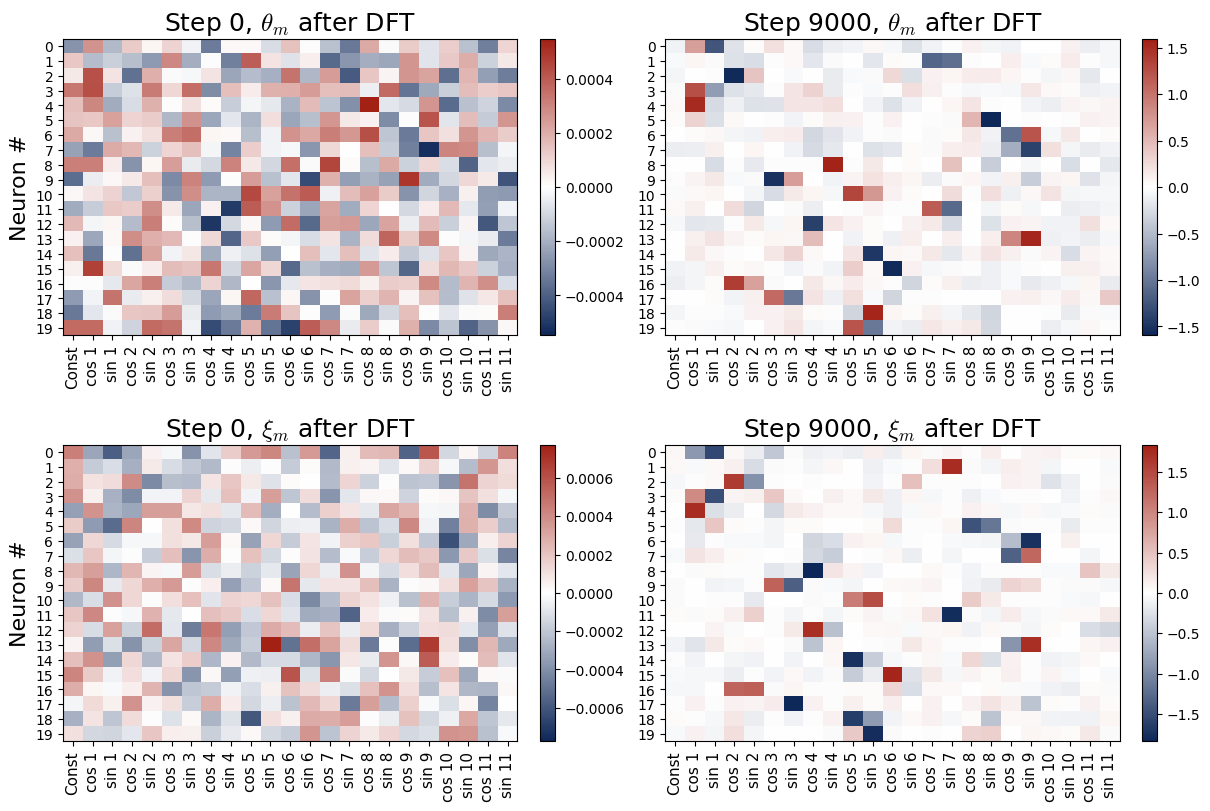

In [15]:
# Create a custom colormap that centers 'cividis' with white at zero
cividis_with_white = LinearSegmentedColormap.from_list(
    'cividis_white_center', 
    ['#0D2758', 'white', '#A32015'],  # Colors at low, middle, and high points in 'cividis'
    N=256
)

def plot_decoded_weights(
    loaded_files,
    fourier_basis,
    fourier_basis_names,
    keys,
    num_components=20
):
    """
    Plots decoded W_in and W_out for each key in `keys`.

    Parameters
    ----------
    loaded_files : list of dict
        Each element is a dict containing 'mlp.W_in' and 'mlp.W_out'.
    fourier_basis : np.ndarray
        Your Fourier basis matrix of shape (p, p).
    fourier_basis_names : list of str
        Names/labels for each Fourier mode (length p).
    keys : list of int
        Indices into loaded_files to plot.
    num_components : int, optional
        How many top components (rows) to show, by default 20.
    """
    n = len(keys)
    #fig, axes = plt.subplots(2, n, figsize=(18, 3.3 * n), gridspec_kw={"hspace": 0.05}, constrained_layout=True)
    fig, axes = plt.subplots(2, n, figsize=(12, 4 * n), gridspec_kw={"hspace": 0.05}, constrained_layout=True)

    # Ensure axes is always 2×n
    if n == 1:
        axes = axes.reshape(2, 1)

    x_locs = np.arange(len(fourier_basis_names))
    y_locs = np.arange(num_components)

    for col, key in enumerate(keys):
        W_in = loaded_files[key]['mlp.W_in']
        W_out = loaded_files[key]['mlp.W_out']

        # --- Decoded W_in on row 0, col `col`
        data_in = (W_in @ fourier_basis.T)[:num_components]
        abs_max_in = np.abs(data_in).max()
        ax_in = axes[0, col]
        im_in = ax_in.imshow(
            data_in,
            cmap=cividis_with_white,
            vmin=-abs_max_in,
            vmax= abs_max_in,
            aspect='auto'
        )
        ax_in.set_title(rf'Step {key}, $\theta_m$ after DFT', fontsize=18)
        ax_in.set_xticks(x_locs)
        ax_in.set_xticklabels(fourier_basis_names, rotation=90, fontsize=11)
        ax_in.set_yticks(y_locs)
        ax_in.set_yticklabels(y_locs)
        if key == 0: ax_in.set_ylabel('Neuron #', fontsize=16)
        fig.colorbar(im_in, ax=ax_in)

        # --- Decoded W_out on row 1, col `col`
        data_out = (W_out.T @ fourier_basis.T)[:num_components]
        abs_max_out = np.abs(data_out).max()
        ax_out = axes[1, col]
        im_out = ax_out.imshow(
            data_out,
            cmap=cividis_with_white,
            vmin=-abs_max_out,
            vmax= abs_max_out,
            aspect='auto'
        )
        ax_out.set_title(rf'Step {key}, $\xi_m$ after DFT', fontsize=18)
        ax_out.set_xticks(x_locs)
        ax_out.set_xticklabels(fourier_basis_names, rotation=90, fontsize=11)
        ax_out.set_yticks(y_locs)
        ax_out.set_yticklabels(y_locs)
        if key == 0: ax_out.set_ylabel('Neuron #', fontsize=16)
        fig.colorbar(im_out, ax=ax_out)
    
    #plt.tight_layout()
    #plt.savefig('single_freq_relu_full_random_init.jpg', format='jpg', dpi=300, bbox_inches='tight')
    plt.show()


# Example usage:
keys = [0, 9000]  # whatever subset of loaded_files you want
plot_decoded_weights(loaded_files, fourier_basis, fourier_basis_names, keys, num_components=20)


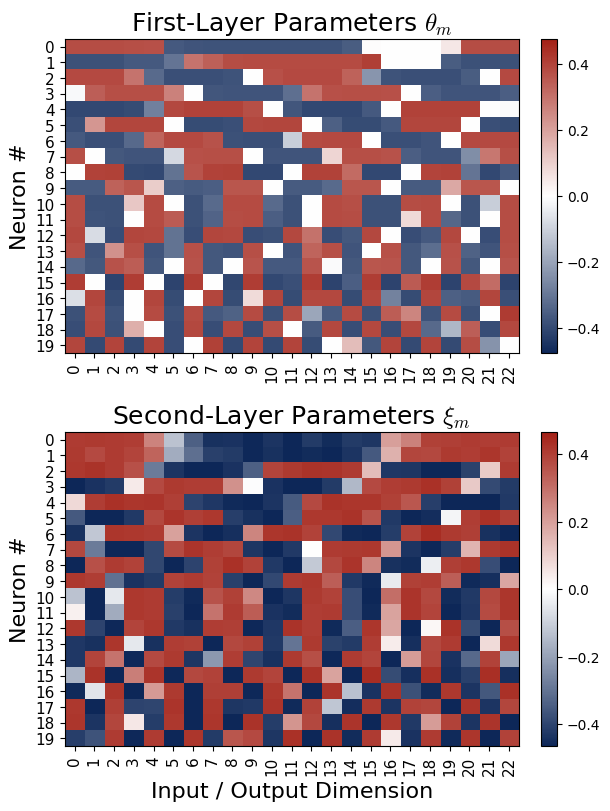

In [16]:
# 1. Define the custom colormap
colors = ['#0D2758', '#60656F', '#DEA54B', '#A32015', '#347186']

cividis_with_white = LinearSegmentedColormap.from_list(
    'cividis_white_center',
    ['#0D2758', 'white', '#A32015'],
    N=256
)

# 2. Prepare data for plotting (as per your provided code)
# arr = np.array(coeff_in_scale_ls_all)
# # find the 20th largest value
# threshold = np.partition(arr, -21)[-21]
# # mask all entries ≥ that threshold
# mask = arr >= threshold #1.79#2.425 # Example threshold
# max_freq_ls = np.array(max_freq_ls)
freq_ls = np.array(max_freq_ls[240:260])
W_in_data_filtered = model_load['mlp.W_in'][240:260]
W_out_T_data_filtered = model_load['mlp.W_out'].T[240:260]

# The following operations can error if freq_ls is empty,
# leading to ranked_W_in_data / ranked_W_out_T_data being empty,
# and then the .max() calls below will raise a ValueError.
# This follows your request to adhere to the original code structure.
sorted_indices = np.argsort(freq_ls)
ranked_freq_ls = freq_ls[sorted_indices]
ranked_W_in_data = W_in_data_filtered[sorted_indices, :]
ranked_W_out_T_data = W_out_T_data_filtered[sorted_indices, :]

# 3. Create the figure and subplots
# Figure size adapted from the example's (12, 4*n) for (2,n) subplots.
# For this (2,1) layout (n=1 equivalent column), (7,9) provides a balanced look.
# gridspec_kw is also from the example to control spacing.
fig, axes = plt.subplots(2, 1, figsize=(6, 8), constrained_layout=True, gridspec_kw={"hspace": 0.05})

# --- Plot for W_in (Top Plot) ---
ax_in = axes[0]
abs_max_in = np.abs(ranked_W_in_data).max() * 1.15 # Your original scaling
im_in = ax_in.imshow(
    ranked_W_in_data,
    cmap=cividis_with_white,
    vmin=-abs_max_in,
    vmax=abs_max_in,
    aspect='auto'
)
ax_in.set_title(r'First-Layer Parameters $\theta_m$', fontsize=18) # Title fontsize from example
fig.colorbar(im_in, ax=ax_in)

# X/Y axis styling based on example
num_rows_in = ranked_W_in_data.shape[0]
num_cols_in = ranked_W_in_data.shape[1]
y_locs_in = np.arange(num_rows_in)
x_locs_in = np.arange(num_cols_in) # Assuming columns are simple indices

ax_in.set_yticks(y_locs_in)
ax_in.set_yticklabels(y_locs_in, fontsize=11) # Tick label fontsize from example
ax_in.set_ylabel('Neuron #', fontsize=16)     # Y-axis label and fontsize from example

ax_in.set_xticks(x_locs_in)
# Using column indices as x-tick labels, styled as per example
ax_in.set_xticklabels(x_locs_in, rotation=90, fontsize=11)
# Your original ax_in.set_xlabel is replaced by these more specific tick labels

# --- Plot for W_out.T (Bottom Plot) ---
ax_out = axes[1]
abs_max_out = np.abs(ranked_W_out_T_data).max() * 0.95 # Your original scaling
im_out = ax_out.imshow(
    ranked_W_out_T_data,
    cmap=cividis_with_white,
    vmin=-abs_max_out,
    vmax=abs_max_out,
    aspect='auto'
)
ax_out.set_title(r'Second-Layer Parameters $\xi_m$', fontsize=18) # Title fontsize from example
fig.colorbar(im_out, ax=ax_out)

# X/Y axis styling based on example
num_rows_out = ranked_W_out_T_data.shape[0]
num_cols_out = ranked_W_out_T_data.shape[1]
y_locs_out = np.arange(num_rows_out)
x_locs_out = np.arange(num_cols_out) # Assuming columns are simple indices

ax_out.set_yticks(y_locs_out)
ax_out.set_yticklabels(y_locs_out, fontsize=11) # Tick label fontsize from example
ax_out.set_ylabel('Neuron #', fontsize=16)     # Y-axis label and fontsize from example

ax_out.set_xticks(x_locs_out)
# Using column indices as x-tick labels, styled as per example
ax_out.set_xticklabels(x_locs_out, rotation=90, fontsize=11)
ax_out.set_xlabel('Input / Output Dimension', fontsize=16)
# Your original ax_out.set_xlabel is replaced
#plt.savefig('figures/full_training_para_origin.jpg', format='jpg', dpi=300, bbox_inches='tight')
# 4. Display the plot
plt.show()

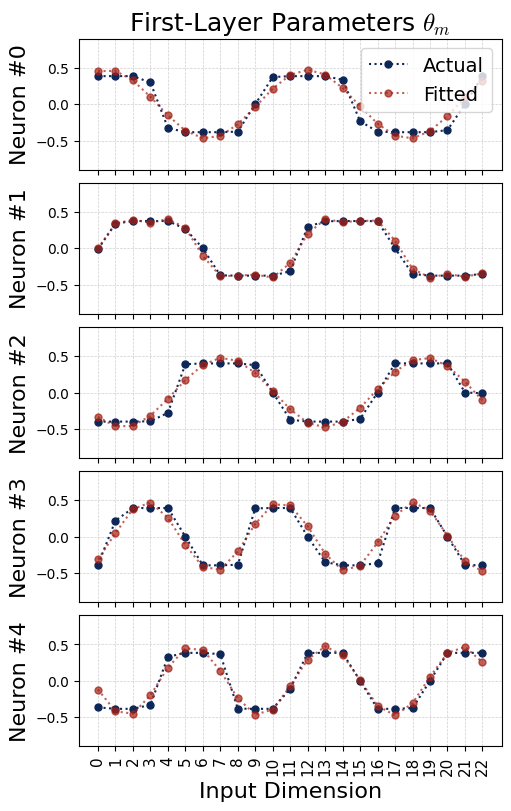

In [17]:
# assume ranked_W_in_data is a pandas DataFrame or a 2D NumPy array
top5 = ranked_W_in_data.iloc[2:7] if hasattr(ranked_W_in_data, 'iloc') else ranked_W_in_data[2:7]

fig, axes = plt.subplots(
    nrows=5,
    ncols=1,
    figsize=(5, 8),
    constrained_layout=True,
    gridspec_kw={'hspace': 0.02}
)

for i, ax in enumerate(axes):
    data = top5.iloc[i].values if hasattr(top5, 'iloc') else top5[i]
    data_est = (p := data @ fourier_basis.T) * np.isin(np.arange(p.shape[0]), np.argpartition(-np.abs(p), 2)[:2]) @ fourier_basis
    ax.plot(data, marker='o', markersize=5, color=colors[0], linewidth=1.5, linestyle=':', label="Actual")
    ax.plot(data_est, marker='o', markersize=5, color=colors[3], linewidth=1.5, linestyle=':', alpha=0.7, label="Fitted")
    ax.set_ylim(-0.9, 0.9)
    ax.set_ylabel(f'Neuron #{i}', fontsize=16)
    positions = np.arange(len(x_locs_out))
     # set common x-ticks for vertical grid lines
    ax.set_xticks(positions)
    # draw grid on both x and y axes
    ax.grid(True,
            which='major',
            axis='both',        # <--- grid on both axes
            linestyle='--',
            linewidth=0.5,
            alpha=0.6)

    # only bottom axis shows labels
    if i < len(axes) - 1:
        ax.set_xticklabels([])

# configure bottom subplot's ticks and labels properly
ax_bottom = axes[-1]
ax_bottom.set_xlabel('Input Dimension', fontsize=16)

# define tick positions (must match number of labels)
positions = np.arange(len(x_locs_out))
ax_bottom.set_xticks(positions)
ax_bottom.set_xticklabels(x_locs_out, rotation=90, fontsize=11)
axes[0].set_title(r'First-Layer Parameters $\theta_m$', fontsize=18)
axes[0].legend(fontsize=14, loc="upper right")
#plt.savefig('figures/full_training_para_origin_lineplot_in.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

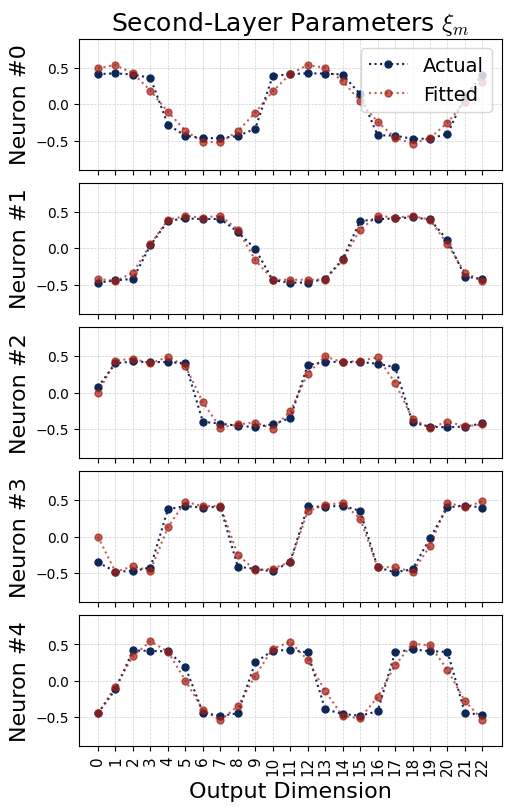

In [18]:
# assume ranked_W_in_data is a pandas DataFrame or a 2D NumPy array
top5 = ranked_W_out_T_data.iloc[2:7] if hasattr(ranked_W_out_T_data, 'iloc') else ranked_W_out_T_data[2:7]

fig, axes = plt.subplots(
    nrows=5,
    ncols=1,
    figsize=(5, 8),
    constrained_layout=True,
    gridspec_kw={'hspace': 0.02}
)

for i, ax in enumerate(axes):
    data = top5.iloc[i].values if hasattr(top5, 'iloc') else top5[i]
    data_est = (p := data @ fourier_basis.T) * np.isin(np.arange(p.shape[0]), np.argpartition(-np.abs(p), 2)[:2]) @ fourier_basis
    ax.plot(data, marker='o', markersize=5, color=colors[0], linewidth=1.5, linestyle=':', label="Actual")
    ax.plot(data_est, marker='o', markersize=5, color=colors[3], linewidth=1.5, linestyle=':', alpha=0.7, label="Fitted")
    ax.set_ylim(-0.9, 0.9)
    ax.set_ylabel(f'Neuron #{i}', fontsize=16)
     # set common x-ticks for vertical grid lines
    ax.set_xticks(positions)
    # draw grid on both x and y axes
    ax.grid(True,
            which='major',
            axis='both',        # <--- grid on both axes
            linestyle='--',
            linewidth=0.5,
            alpha=0.6)

    # only bottom axis shows labels
    if i < len(axes) - 1:
        ax.set_xticklabels([])

# configure bottom subplot's ticks and labels properly
ax_bottom = axes[-1]
ax_bottom.set_xlabel('Output Dimension', fontsize=16)

# define tick positions (must match number of labels)
positions = np.arange(len(x_locs_out))
ax_bottom.set_xticks(positions)
ax_bottom.set_xticklabels(x_locs_out, rotation=90, fontsize=11)
axes[0].legend(fontsize=14, loc="upper right")
axes[0].set_title(r'Second-Layer Parameters $\xi_m$', fontsize=18)
#plt.savefig('figures/full_training_para_origin_lineplot_out.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
coeff_scale_ls = []
coeff_phi_ls = []
freq = 5

for neuron in [i for i, value in enumerate(max_freq_ls) if value == freq]:
    coeff_in_scale, coeff_in_phi = compute_neuron(neuron, max_freq_ls, W_in_decode)
    coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
    coeff_scale_ls.append(coeff_in_scale*coeff_out_scale)
    coeff_phi_ls.append(coeff_in_phi)
    #print(f"Neuron {neuron}: Freq {max_freq_ls[neuron]}, Scale(in,out) {coeff_in_scale: .2f},{coeff_out_scale: .2f}, Phi(out) {normalize_to_pi(coeff_out_phi): .2f}, Phi(in)*2 {normalize_to_pi(2*coeff_in_phi): .2f}")

coeff_scale_ls = np.array(coeff_scale_ls)
coeff_phi_ls = np.array(coeff_phi_ls)

# assume coeff_phi_ls is your 1D array of φₘ
multipliers = [1, 2, 3, 4,5,6,7,8]
results = {}

for m in multipliers:
    mean_cos = np.mean(np.cos(m * coeff_phi_ls))
    mean_sin = np.mean(np.sin(m * coeff_phi_ls))
    results[m] = (mean_cos, mean_sin)

# print them out
for m, (c, s) in results.items():
    print(f"m={m:>1} → ⟨cos({m}φₘ)⟩ = {c:.4f}, ⟨sin({m}φₘ)⟩ = {s:.4f}")


m=1 → ⟨cos(1φₘ)⟩ = 0.0158, ⟨sin(1φₘ)⟩ = -0.0045
m=2 → ⟨cos(2φₘ)⟩ = -0.0382, ⟨sin(2φₘ)⟩ = 0.0406
m=3 → ⟨cos(3φₘ)⟩ = -0.0318, ⟨sin(3φₘ)⟩ = -0.0312
m=4 → ⟨cos(4φₘ)⟩ = -0.0403, ⟨sin(4φₘ)⟩ = -0.0347
m=5 → ⟨cos(5φₘ)⟩ = -0.0403, ⟨sin(5φₘ)⟩ = -0.0231
m=6 → ⟨cos(6φₘ)⟩ = -0.0045, ⟨sin(6φₘ)⟩ = 0.0026
m=7 → ⟨cos(7φₘ)⟩ = -0.0242, ⟨sin(7φₘ)⟩ = 0.0521
m=8 → ⟨cos(8φₘ)⟩ = 0.0016, ⟨sin(8φₘ)⟩ = 0.0254


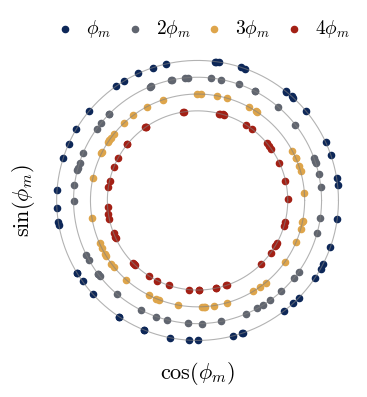

In [20]:
theta = np.linspace(0, 2*np.pi, 300)

# define multipliers and a matching sequence of radii
multipliers = [1, 2, 3, 4]
radii       = [1.0, 0.88, 0.76, 0.64]

fig, ax = plt.subplots(figsize=(4,4))

for m, r in zip(multipliers, radii):
    # draw the circle of radius r
    x_c, y_c = r*np.cos(theta), r*np.sin(theta)
    ax.plot(x_c, y_c, linewidth=0.8, color='gray', alpha=0.6)
    
    # compute and plot points at angles m*φₘ, but on that circle of radius r
    x_pts = r * np.cos(m * coeff_phi_ls)
    y_pts = r * np.sin(m * coeff_phi_ls)
    if m > 1:
        ax.scatter(
            x_pts, y_pts,
            s=20,
            marker='o',
            color=colors[m-1],
            label=fr'${m}\phi_m$'
        )
    else:
        ax.scatter(
            x_pts, y_pts,
            s=20,
            marker='o',
            color=colors[m-1],
            label=fr'$\phi_m$'
        )


# floating legend
ax.legend(
    fontsize=14,
    loc='upper center',
    columnspacing=0.2,
    handletextpad=0.1,
    bbox_to_anchor=(0.5, 1.15),
    ncol=4,
    frameon=False
)

ax.set_xlabel(r'$\cos(\phi_m)$', fontsize=16)
ax.set_ylabel(r'$\sin(\phi_m)$', fontsize=16)

ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
# strip away all axes and spines
#ax.set_axis_off()
#plt.savefig('figures/full_training_phase_distribution.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

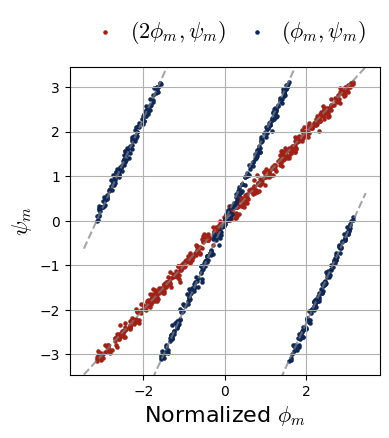

In [21]:
import numpy as np
import matplotlib.pyplot as plt

coeff_2phi_ls_all = np.array([normalize_to_pi(2*φ) for φ in coeff_phi_ls_all])
coeff_psi_ls_all  = np.array(coeff_psi_ls_all)
coeff_phi_ls_all  = np.array(coeff_phi_ls_all)

cond = ((coeff_2phi_ls_all / coeff_psi_ls_all < 0) & (coeff_2phi_ls_all < -2.8)) | ((coeff_2phi_ls_all / coeff_psi_ls_all < 0) & (coeff_2phi_ls_all > 2.8))

fig, ax = plt.subplots(figsize=(4,4))

# scatter points
ax.scatter(
    coeff_2phi_ls_all[~cond],
    coeff_psi_ls_all[~cond],
    marker='.',
    color=colors[3],
    s=20,
    label=r'$(2\phi_m,\psi_m)$'
)
ax.scatter(
    coeff_phi_ls_all[~cond],
    coeff_psi_ls_all[~cond],
    marker='.',
    color=colors[0],
    s=20,
    label=r'$(\phi_m,\psi_m)$'
)

# add reference lines
x_min, x_max = ax.get_xlim()
x_line = np.linspace(x_min, x_max, 200)
ax.plot(x_line,   x_line,       linestyle='--', color='gray', alpha=0.7)
ax.plot(x_line,   2*x_line,     linestyle='--', color='gray', alpha=0.7)
ax.plot(x_line,   2*x_line+2*np.pi, linestyle='--', color='gray', alpha=0.7)
ax.plot(x_line,   2*x_line-2*np.pi, linestyle='--', color='gray', alpha=0.7)

# labels & grid
ax.set_xlabel(r'Normalized $\phi_m$', fontsize=16)
ax.set_ylabel(r'$\psi_m$', fontsize=16)
ax.set_ylim(-np.pi*1.1, np.pi*1.1)
ax.grid(True)

# legend above plot
ax.legend(
    fontsize=16,
    ncol=2,
    loc='upper center',
    frameon=False,
    bbox_to_anchor=(0.5, 1.25),
    columnspacing=0.4,   # horizontal space between columns
    handletextpad=0.1,   # space between marker and text
    labelspacing=0.2,    # vertical space between rows (not used for single row)
    borderaxespad=0.9   # padding between axes and legend box
)

#plt.savefig('figures/full_training_phase_relationship.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()


In [34]:
########## Hook Manager ##########
class HookPoint(nn.Module):
    def __init__(self):
        super().__init__()
        # Lists to store forward and backward hook handles for later removal
        self.fwd_hooks = []  # Forward hooks
        self.bwd_hooks = []  # Backward hooks
    
    def give_name(self, name):
        # Sets a name for the hook point (called during model initialization for tracking)
        self.name = name
    
    def add_hook(self, hook, dir='fwd'):
        # Adds a hook to the module (either forward or backward)
        # hook is a function that takes (activation, hook_name) as input
        # Converts it to PyTorch's hook format, which takes module, input, and output
        def full_hook(module, module_input, module_output):
            # Calls the provided hook function, passing the output (activation) and hook name
            return hook(module_output, name=self.name)
        
        if dir == 'fwd':
            # Registers the full hook as a forward hook and stores the handle
            handle = self.register_forward_hook(full_hook)
            self.fwd_hooks.append(handle)
        elif dir == 'bwd':
            # Registers the full hook as a backward hook and stores the handle
            handle = self.register_backward_hook(full_hook)
            self.bwd_hooks.append(handle)
        else:
            raise ValueError(f"Invalid direction {dir}")  # Raise error if direction is invalid
    
    def remove_hooks(self, dir='fwd'):
        # Removes all hooks of the specified direction
        if (dir == 'fwd') or (dir == 'both'):
            for hook in self.fwd_hooks:
                hook.remove()  # Remove each forward hook
            self.fwd_hooks = []
        if (dir == 'bwd') or (dir == 'both'):
            for hook in self.bwd_hooks:
                hook.remove()  # Remove each backward hook
            self.bwd_hooks = []
        if dir not in ['fwd', 'bwd', 'both']:
            raise ValueError(f"Invalid direction {dir}")  # Raise error if direction is invalid
    
    def forward(self, x):
        # By default, acts as an identity function, simply returning its input
        return x

# Embed & Unembed
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        # Weight matrix for embedding, initialized with standard deviation scaled by sqrt(d_model)
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_model))
        self.d_vocab = d_vocab
    
    def forward(self, x):
        # Convert input tokens to embedded vectors using a matrix product
        # Input x is expected to be of shape (batch_size, 2), indexing tokens in the vocabulary
        # Convert input to a tensor if it's not already
        if isinstance(x, list):
            x = torch.tensor(x, device=self.W_E.device)
        # Validate shape
        assert x.ndim == 2 and x.shape[1] == 2, f"Expected input shape (batch_size, 2), got {x.shape}"

        embed = F.one_hot(x, num_classes=self.d_vocab).float().sum(dim=1).unsqueeze(1)
        #embed = torch.einsum('dbp -> bpd', self.W_E[:, x]).sum(dim=1).unsqueeze(1)  # This operation gathers the embeddings for the input tokens      
        return embed

class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon=1e-4, model=[None]):
        super().__init__()
        self.model = model
        # Learnable scale and shift parameters
        self.w_ln = nn.Parameter(torch.ones(d_model))
        self.b_ln = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon
    
    def forward(self, x):
        if self.model[0].use_ln:
            # Normalize the input
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            # Apply learnable scale and shift
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x

# MLP Layers
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, d_vocab, act_type, model):
        super().__init__()
        self.model = model
        # Input and output weight matrices for the feedforward layer
        self.W_in = nn.Parameter(0.001 * torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        #self.b_in = nn.Parameter(torch.zeros(d_mlp))
        self.W_out = nn.Parameter(0.001 * torch.randn(d_vocab, d_mlp)/np.sqrt(d_model))
        #self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        # self.ln = LayerNorm(d_mlp, model=self.model)
        self.hook_pre = HookPoint()
        self.hook_post = HookPoint()
        assert act_type in ['ReLU', 'GeLU', 'Quad', 'Id']
        #fourier_basis, _ = get_fourier_basis(d_vocab)
        self.register_buffer('basis', torch.tensor(fourier_basis))
    
    def quad_act(self, x):
        return torch.log(1+torch.exp(2*x))#torch.abs(x)#x**2#torch.abs(x)

    def forward(self, x):
        # Linear transformation and activation
        #x = self.hook_pre(torch.einsum('md,bpd->bpm', self.W_in @ self.basis, x))
        x = self.hook_pre(torch.einsum('md,bpd->bpm', self.W_in, x))
        if self.act_type == 'ReLU':
            x = F.relu(x)
        elif self.act_type == 'GeLU':
            x = F.gelu(x)
        elif self.act_type == "Quad":
            x = self.quad_act(x)
        elif self.act_type == "Id":
            x = x
        x = self.hook_post(x)
        # Output transformation
        #x = torch.einsum('dm,bpm->bpd', self.basis.T @ self.W_out, x) #+ self.b_out
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) #+ self.b_out
        return x

class EmbedMLP(nn.Module):
    def __init__(self, d_vocab, d_model, d_mlp, act_type, use_cache=False, use_ln=True):
        super().__init__()
        self.cache = {}
        self.use_cache = use_cache

        # Embedding layers
        self.embed = Embed(d_vocab, d_model)
        self.mlp = MLP(d_model, d_mlp, d_vocab, act_type, model=[self])
        # Optional layer normalization at the output
        # self.ln = LayerNorm(d_model, model=[self])
        # Unembedding layer for output logits
        # self.unembed = Unembed(self.embed)#Unembed(d_vocab, d_model)
        self.use_ln = use_ln

        # Assign names to hook points for easier debugging and monitoring
        for name, module in self.named_modules():
            if type(module) == HookPoint:
                module.give_name(name)
    
    def forward(self, x):
        # Pass input through embedding layers
        x = self.embed(x)
        # Pass input through MLP
        x = self.mlp(x)        
        # Optional normalization (commented out)
        # x = self.ln(x)
        # Pass through unembedding layer
        # x = self.unembed(x)
        return x.squeeze(1)

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache
    
    def hook_points(self):
        # Gather all hook points in the model for easy access
        return [module for name, module in self.named_modules() if 'hook' in name]

    def remove_all_hooks(self):
        # Remove all hooks for cleaner training or evaluation
        for hp in self.hook_points():
            hp.remove_hooks('fwd')
            hp.remove_hooks('bwd')
    
    def cache_all(self, cache, incl_bwd=False):
        # Caches all activations wrapped in a HookPoint
        def save_hook(tensor, name):
            cache[name] = tensor.detach()
        def save_hook_back(tensor, name):
            cache[name + '_grad'] = tensor[0].detach()
        for hp in self.hook_points():
            hp.add_hook(save_hook, 'fwd')
            if incl_bwd:
                hp.add_hook(save_hook_back, 'bwd')

In [35]:
modified_model = EmbedMLP(d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, act_type="Quad", use_cache=False)
modified_model.to(device)
modified_model.load_state_dict(model_load)

all_cache = {}
modified_model.remove_all_hooks()
modified_model.cache_all(all_cache)

logits = modified_model(all_data).squeeze(1)
loss = cross_entropy_high_precision(logits, all_labels)
acc = acc_rate(logits, all_labels)
print(f"Modified Loss after Changing Activation: {loss.item()}")
print(f"Modified Accuracy after Changing Activation: {acc}")

Modified Loss after Changing Activation: 0.0005894869100302458
Modified Accuracy after Changing Activation: 1.0


/tmp/tmp.V3NPWMoUqD/ipykernel_261533/2688224342.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('basis', torch.tensor(fourier_basis))
